In [35]:
!/opt/bin/nvidia-smi

Sat Nov 14 05:21:51 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    28W /  70W |   1311MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [44]:
!rm -rf /content/sample_data
!rm -rf /content/data/results

In [34]:
import os, time
import matplotlib.pyplot as plt
import itertools
import pickle
import imageio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import torchvision.models as models
import numpy as np

In [27]:
def get_cuda(tensor):
    if torch.cuda.is_available():
        tensor = tensor.cuda()
    return tensor

class Encoder(nn.Module):
    def __init__(self, opt):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.x_to_mu = nn.Linear(512,opt.n_z)
        self.x_to_logvar = nn.Linear(512, opt.n_z)

    def reparameterize(self, x):
        mu = self.x_to_mu(x)
        logvar = self.x_to_logvar(x)
        z = torch.randn(mu.size())
        z = get_cuda(z)
        z = mu + z * torch.exp(0.5 * logvar)
        kld = (-0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), 1))
        return z, kld

    def forward(self, x):
        x = self.fc1(x).squeeze()
        z, kld = self.reparameterize(x)
        return z, kld


class Generator(nn.Module):
    # initializers
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1_1 = nn.Linear(100, 256)
        self.fc1_1_bn = nn.BatchNorm1d(256)
        self.fc1_2 = nn.Linear(10, 256)
        self.fc1_2_bn = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 512)
        self.fc2_bn = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(512, 1024)
        self.fc3_bn = nn.BatchNorm1d(1024)
        self.fc4 = nn.Linear(1024, 784)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input):
        x = F.relu(self.fc1_1_bn(self.fc1_1(input)))
        x = F.relu(self.fc2_bn(self.fc2(x)))
        x = F.relu(self.fc3_bn(self.fc3(x)))
        x = F.tanh(self.fc4(x))

        return x


class Discriminator(nn.Module):
    # initializers
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1_1 = nn.Linear(784, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc2_bn = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(512, 256)
        self.fc3_bn = nn.BatchNorm1d(256)
        self.fc4 = nn.Linear(256, 1)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, x):
        x = F.leaky_relu(self.fc1_1(x), 0.2)
        x = F.leaky_relu(self.fc2_bn(self.fc2(x)), 0.2)
        x = F.leaky_relu(self.fc3_bn(self.fc3(x)), 0.2)
        x = F.sigmoid(self.fc4(x))

        return x

In [38]:
import torch as T
import random
import torchvision.utils as utils
import argparse

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)


save_path = "data/saved_models/saved_model.tar"

if not os.path.exists("data/saved_models"):
    os.makedirs("data/saved_models")

parser = argparse.ArgumentParser()
parser.add_argument('--batch_size', type=int, default=128)
parser.add_argument('--epochs', type=int, default=100)
parser.add_argument('--lr_e', type=float, default=0.0002)
parser.add_argument('--lr_g', type=float, default=0.0002)
parser.add_argument('--lr_d', type=float, default=0.0002)
parser.add_argument("--num_workers", type=int, default=4)
parser.add_argument("--n_samples", type=int, default=100)
parser.add_argument('--n_z', type=int, default=100)
parser.add_argument('--img_size', type=int, default=128)
parser.add_argument('--w_kld', type=float, default=1)
parser.add_argument('--w_loss_g', type=float, default=0.01)
parser.add_argument('--w_loss_gd', type=float, default=1)

def str2bool(v):
    if v.lower() == 'true':
        return True
    else:
        return False

parser.add_argument('--resume_training', type=str2bool, default=False)
parser.add_argument('--to_train', type=str2bool, default=True)

opt = parser.parse_known_args()[0]

print(opt)

Namespace(batch_size=128, epochs=100, img_size=128, lr_d=0.0002, lr_e=0.0002, lr_g=0.0002, n_samples=100, n_z=100, num_workers=4, resume_training=False, to_train=True, w_kld=1, w_loss_g=0.01, w_loss_gd=1)


In [7]:
# data_loader
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
])

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True, transform=transform),
    batch_size=opt.batch_size, shuffle=True)

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch: 0 time: 43.00167465209961 loss_D: 1.0111 loss_G: 3.4992 loss_GD: 0.5836 loss_kld: 0.4156
epoch: 1 time: 42.73189377784729 loss_D: 0.7519 loss_G: 3.3565 loss_GD: 0.6766 loss_kld: 0.0756
epoch: 2 time: 42.15603256225586 loss_D: 0.7257 loss_G: 3.3649 loss_GD: 0.6838 loss_kld: 0.0528
epoch: 3 time: 42.15479588508606 loss_D: 0.7179 loss_G: 3.3743 loss_GD: 0.6869 loss_kld: 0.0360
epoch: 4 time: 41.96031188964844 loss_D: 0.7108 loss_G: 3.3419 loss_GD: 0.6896 loss_kld: 0.0300
epoch: 5 time: 41.71969175338745 loss_D: 0.7096 loss_G: 3.3338 loss_GD: 0.6911 loss_kld: 0.0268
epoch: 6 time: 42.033204317092896 loss_D: 0.7109 loss_G: 3.2993 loss_GD: 0.6911 loss_kld: 0.0181
epoch: 7 time: 42.58962655067444 loss_D: 0.7049 loss_G: 3.2909 loss_GD: 0.6909 loss_kld: 0.0199
epoch: 8 time: 42.476099252700806 loss_D: 0.7050 loss_G: 3.2990 loss_GD: 0.6912 loss_kld: 0.0209
epoch: 9 time: 42.15470623970032 loss_D: 0.7002 loss_G: 3.2674 loss_GD: 0.6920 loss_kld: 0.0148
epoch: 10 time: 43.031596660614014 los

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:136: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


epoch: 21 time: 42.33372449874878 loss_D: 0.7004 loss_G: 3.1486 loss_GD: 0.6912 loss_kld: 0.0041
epoch: 22 time: 41.981560707092285 loss_D: 0.6974 loss_G: 3.1765 loss_GD: 0.6930 loss_kld: 0.0075
epoch: 23 time: 41.747955322265625 loss_D: 0.6957 loss_G: 3.1370 loss_GD: 0.6937 loss_kld: 0.0023
epoch: 24 time: 41.78052353858948 loss_D: 0.6963 loss_G: 3.1152 loss_GD: 0.6915 loss_kld: 0.0020
epoch: 25 time: 41.3324408531189 loss_D: 0.6966 loss_G: 3.1225 loss_GD: 0.6942 loss_kld: 0.0048
epoch: 26 time: 41.874067068099976 loss_D: 0.6959 loss_G: 3.1175 loss_GD: 0.6927 loss_kld: 0.0020
epoch: 27 time: 41.86005115509033 loss_D: 0.6964 loss_G: 3.1259 loss_GD: 0.6926 loss_kld: 0.0033
epoch: 28 time: 41.60477304458618 loss_D: 0.6981 loss_G: 3.1179 loss_GD: 0.6921 loss_kld: 0.0036
epoch: 29 time: 41.526169538497925 loss_D: 0.6961 loss_G: 3.1404 loss_GD: 0.6931 loss_kld: 0.0049
epoch: 30 time: 41.411941051483154 loss_D: 0.6967 loss_G: 3.1460 loss_GD: 0.6933 loss_kld: 0.0044
epoch: 31 time: 41.0071682

KeyboardInterrupt: ignored

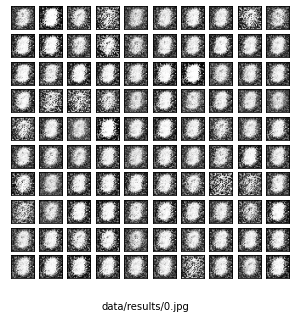

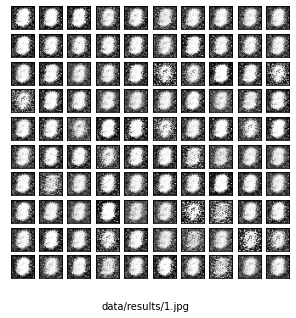

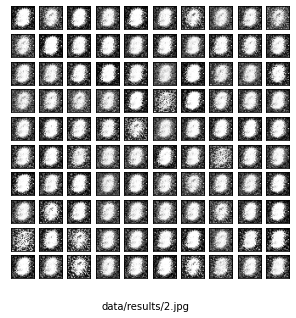

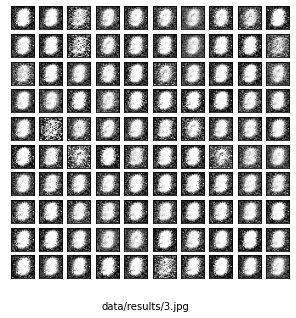

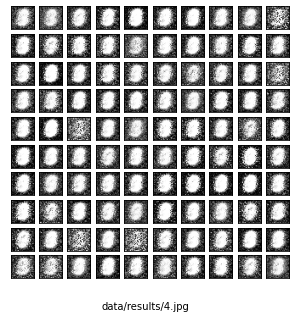

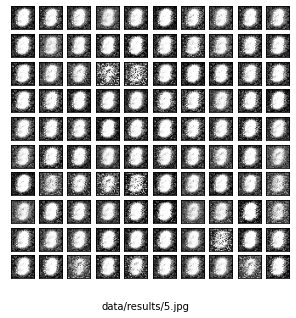

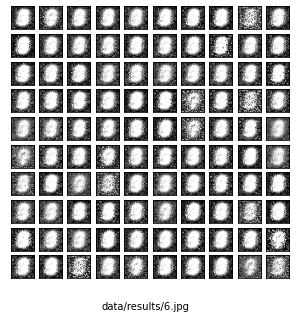

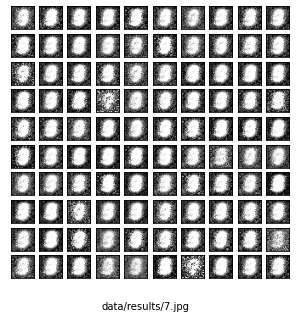

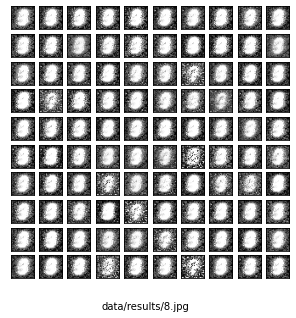

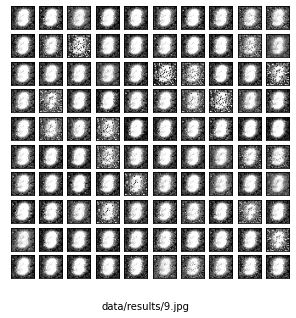

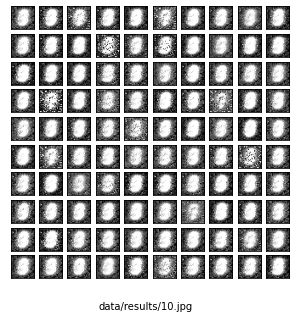

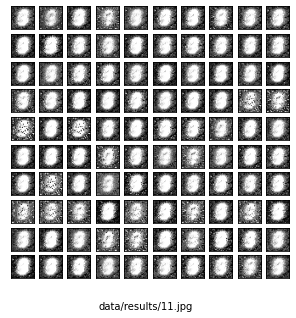

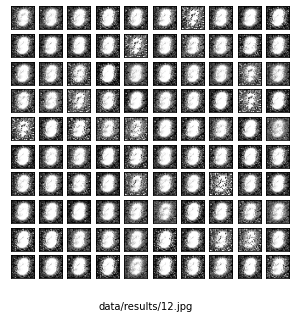

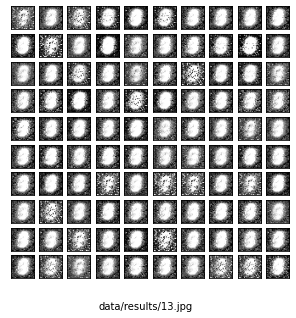

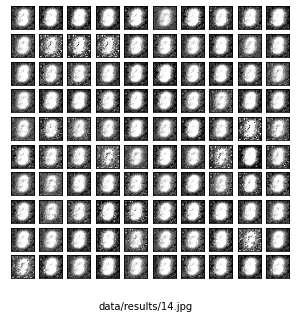

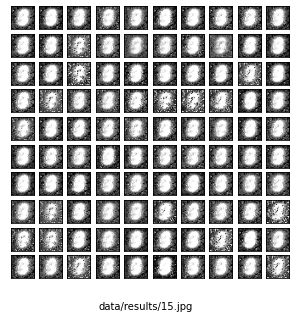

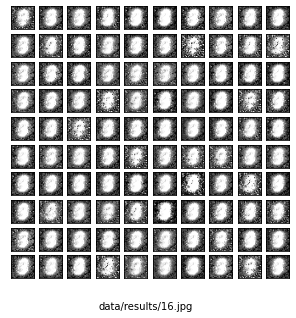

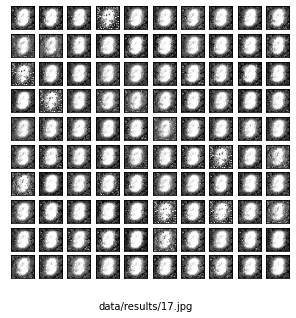

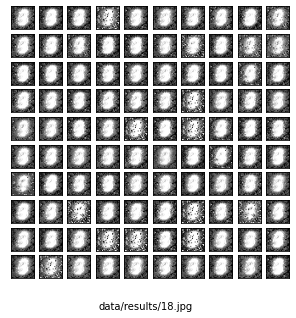

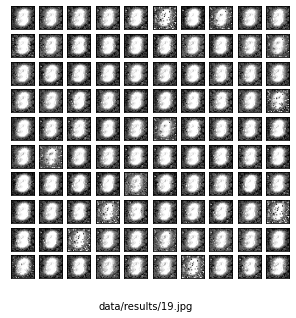

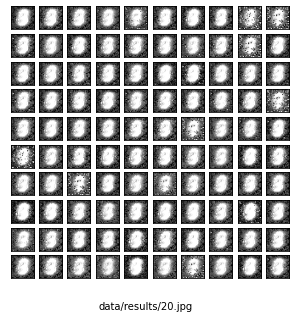

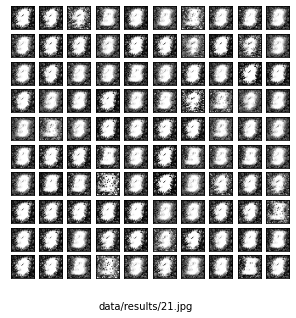

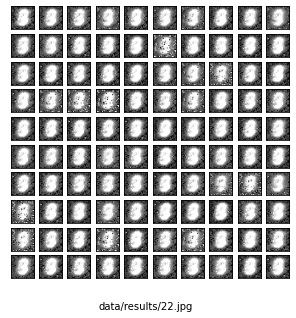

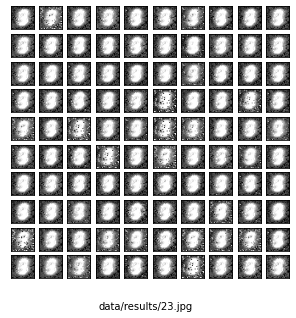

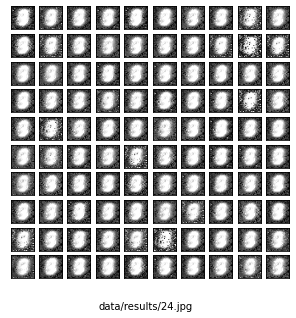

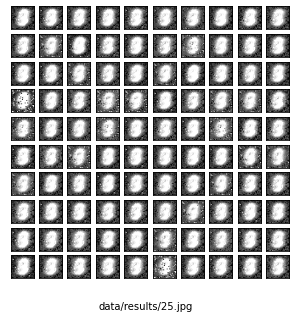

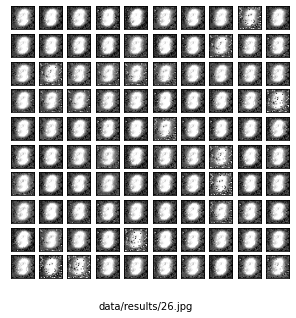

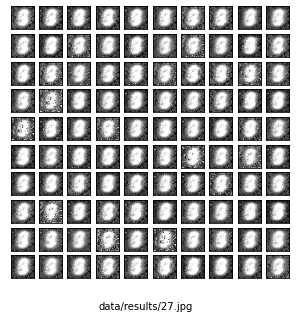

Error in callback <function flush_figures at 0x7f6647dce2f0> (for post_execute):


KeyboardInterrupt: ignored

In [43]:
manual_seed = random.randint(1, 10000)
random.seed(manual_seed)
T.manual_seed(manual_seed)
if T.cuda.is_available():
    T.cuda.manual_seed_all(manual_seed)

BCE_loss = nn.BCELoss()

E = get_cuda(Encoder(opt))
G = get_cuda(Generator().apply(weights_init))
D = get_cuda(Discriminator().apply(weights_init))

E_trainer = T.optim.Adam(E.parameters(), lr=opt.lr_e)
G_trainer = T.optim.Adam(G.parameters(), lr=opt.lr_g, betas=(0.5, 0.999))
D_trainer = T.optim.Adam(D.parameters(), lr=opt.lr_d, betas=(0.5, 0.999))


def train_batch(x_r):
    batch_size = x_r.size(0)
    x_r = x_r.view(-1, 28 * 28)
    y_real = get_cuda(T.ones(batch_size))
    y_fake = get_cuda(T.zeros(batch_size))
    
    #Extract latent_z corresponding to real images
    z, kld = E(x_r)
    kld = kld.mean()
    #Extract fake images corresponding to real images
    x_f = G(z)

    #Extract latent_z corresponding to noise
    z_p = T.randn(batch_size, opt.n_z)
    z_p = get_cuda(z_p)
    #Extract fake images corresponding to noise
    x_p = G(z_p)

    #Compute D(x) for real and fake images along with their features
    ld_r = D(x_r).squeeze()
    ld_f = D(x_f).squeeze()
    ld_p = D(x_p).squeeze()

    #------------D training------------------
    loss_D = BCE_loss(ld_r, y_real) + 0.5*(BCE_loss(ld_f, y_fake) + BCE_loss(ld_p, y_fake))    

    #------------E & G training--------------

    #loss corresponding to -log(D(G(z_p)))
    loss_GD = BCE_loss(ld_p, y_real)
    #pixel wise matching loss and discriminator's feature matching loss
    loss_G = 0.5 * (0.01*(x_f - x_r).pow(2).sum()) / batch_size

    E_trainer.zero_grad()
    G_trainer.zero_grad()
    D_trainer.zero_grad()
    loss_D.backward(retain_graph = True)
    (opt.w_kld*kld+opt.w_loss_g*loss_G+opt.w_loss_gd*loss_GD).backward()
    D_trainer.step()
    E_trainer.step()
    G_trainer.step()


    return loss_D.item(), loss_G.item(), loss_GD.item(), kld.item()

def load_model_from_checkpoint():
    global E, G, D, E_trainer, G_trainer, D_trainer
    checkpoint = T.load(save_path)
    E.load_state_dict(checkpoint['E_model'])
    G.load_state_dict(checkpoint['G_model'])
    D.load_state_dict(checkpoint['D_model'])
    E_trainer.load_state_dict(checkpoint['E_trainer'])
    G_trainer.load_state_dict(checkpoint['G_trainer'])
    D_trainer.load_state_dict(checkpoint['D_trainer'])
    return checkpoint['epoch']

def training():
    start_time = time.time()
    start_epoch = 0
    if opt.resume_training:
        start_epoch = load_model_from_checkpoint()
    
    
    for epoch in range(start_epoch, opt.epochs):
        E.train()
        G.train()
        D.train()

        T_loss_D = []
        T_loss_G = []
        T_loss_GD = []
        T_loss_kld = []

        epoch_start_time = time.time()
        for x, _ in train_loader:
            x = get_cuda(x)
            loss_D, loss_G, loss_GD, loss_kld = train_batch(x)
            T_loss_D.append(loss_D)
            T_loss_G.append(loss_G)
            T_loss_GD.append(loss_GD)
            T_loss_kld.append(loss_kld)
        epoch_end_time = time.time()
        per_epoch_ptime = epoch_end_time - epoch_start_time

        T_loss_D = np.mean(T_loss_D)
        T_loss_G = np.mean(T_loss_G)
        T_loss_GD = np.mean(T_loss_GD)
        T_loss_kld = np.mean(T_loss_kld)

        print("epoch:", epoch,"time:",per_epoch_ptime, "loss_D:", "%.4f"%T_loss_D, "loss_G:", "%.4f"%T_loss_G, "loss_GD:", "%.4f"%T_loss_GD, "loss_kld:", "%.4f"%T_loss_kld)

        generate_samples("data/results/%d.jpg" % epoch)
        T.save({
            'epoch': epoch + 1,
            "E_model": E.state_dict(),
            "G_model": G.state_dict(),
            "D_model": D.state_dict(),
            'E_trainer': E_trainer.state_dict(),
            'G_trainer': G_trainer.state_dict(),
            'D_trainer': D_trainer.state_dict()
        }, save_path)
    end_time = time.time()
    total_ptime = end_time - start_time
    print("total_ptime:",total_ptime)

def generate_samples(img_name):
    z_p = T.randn(opt.n_samples, opt.n_z)
    z_p = get_cuda(z_p)
    E.eval()
    G.eval()
    D.eval()
    with T.autograd.no_grad():
        x_p = G(z_p)
    E.train()
    G.train()
    D.train() 

    size_figure_grid = 10
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
    for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)

    for k in range(10*10):
        i = k // 10
        j = k % 10
        ax[i, j].cla()
        ax[i, j].imshow(x_p[k].cpu().data.view(28, 28).numpy(), cmap='gray')

    label = img_name
    fig.text(0.5, 0.04, label, ha='center')
    plt.savefig(label)



if __name__ == "__main__":
    if opt.to_train:
        training()
    else:
        checkpoint = T.load(save_path)
        G.load_state_dict(checkpoint['G_model'])
        generate_samples("data/testing_img.jpg")